In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel
from sklearn.model_selection import KFold
from scipy.stats import norm
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import seaborn as sns
sns.set_theme()

# NSW Experimental Data

In [2]:
# Dehejia-Wahba sample: 185 treated + 260 control units
# outcome of interest "re78" = earnings in 1978 
# pretreatment outcomes "re74" and "re75" = earnings in 1974 and 1975
# covariates: age, education, black, hispanic, married, nodegree
df_dw = pd.read_stata("data/NSW/nsw_dw.dta") 
df_dw = df_dw.drop(columns='data_id')   # (445, 10)

# we add unemployment indicators for future use
# unemployed in 1974 or 1975
df_dw['u74'] = np.where(df_dw['re74']==0, 1, 0)
df_dw['u75'] = np.where(df_dw['re75']==0, 1, 0)

# treatment group
dw_t = df_dw[df_dw['treat']==1] # (185, 12)
N_t = dw_t.shape[0]
Y_t = dw_t['re78'].to_numpy()   # observed outcomes
X_t = dw_t.drop(columns=['treat','re78']).to_numpy()    # (185, 10)
X_t = X_t / np.std(X_t, axis=0, ddof=1)   # standardize 
d = X_t.shape[1]

# control group
dw_c = df_dw[df_dw['treat']==0] # (260, 12)
N_c = dw_c.shape[0]
Y_c = dw_c['re78'].to_numpy()   # observed outcomes
X_c = dw_c.drop(columns=['treat','re78']).to_numpy()    # (260, 10)
X_c = X_c / np.std(X_c, axis=0, ddof=1)  # standardize

print('ATT by mean difference =', np.mean(Y_t) - np.mean(Y_c))

ATT by mean difference = 1794.3433


Linear

In [3]:
# kernel matrices (linear)
K_c = X_c @ X_c.T / d  # (N_c, N_c)
K_ct = X_c @ X_t.T / d  # (N_c, N_t)
K_t = X_t @ X_t.T / d  # (N_t, N_t)

# load the saved results
pi_lin1 = np.load('results/NSW_lin1.npy')
pi_lin0001 = np.load('results/NSW_lin0001.npy')

Y_c_lin1 = N_t * Y_c @ pi_lin1
tau_lin1 = Y_t - Y_c_lin1

Y_c_lin0001 = N_t * Y_c @ pi_lin0001
tau_lin0001 = Y_t - Y_c_lin0001

Kernel ridge regression

In [4]:
np.random.seed(123)
rho_range = np.array([0.1, 0.5, 1, 5, 10])*N_c

K = 5
err = np.zeros((len(rho_range), K))
sigma_estimates = np.zeros(len(rho_range))
f0_norm_estimates = np.zeros(len(rho_range))

for i, rho in enumerate(rho_range):
    kf = KFold(n_splits=K, shuffle=True)

    for j, (train_index, test_index) in enumerate(kf.split(X_c)):
        X_c_tr = X_c[train_index,:]
        X_c_test = X_c[test_index,:]

        Y_c_tr = Y_c[train_index]
        Y_c_test = Y_c[test_index]

        K_c_tr = X_c_tr @ X_c_tr.T / d
        N_c_tr = X_c_tr.shape[0]
        alpha_hat_tr = np.linalg.pinv(K_c_tr + np.eye(N_c_tr)*rho) @ Y_c_tr
        K_c_test = X_c_test @ X_c_tr.T / d        
        err[i,j] = np.mean((Y_c_test - K_c_test @ alpha_hat_tr)**2)
    
    alpha_hat = np.linalg.pinv(K_c + np.eye(N_c)*rho) @ Y_c
    Y_c_fit = K_c @ alpha_hat
    krr_res = Y_c - Y_c_fit
    sigma_estimates[i] = np.std(krr_res, ddof=0)
    f0_norm_estimates[i] = np.sqrt(np.dot(alpha_hat, Y_c_fit))


print(np.mean(err, axis=1))
print(sigma_estimates)
print(f0_norm_estimates)

rho_id = np.argmin(np.mean(err, axis=1))
rho = rho_range[rho_id]
print('rho =', rho) # 26
s_hat = sigma_estimates[rho_id]
f0_norm_hat = f0_norm_estimates[rho_id]
print(f'f0_norm_hat = {f0_norm_hat} and s_hat = {s_hat}')

[29974441.64378881 30530940.10608592 31097641.98506593 35307838.61311819
 39047243.74752943]
[5371.5030215  5447.15297613 5474.00988223 5491.30399729 5486.8264315 ]
[2784.03649636 1822.36590647 1580.56470333  996.8103041   697.85356162]
rho = 26.0
f0_norm_hat = 2784.036496358749 and s_hat = 5371.503021500423


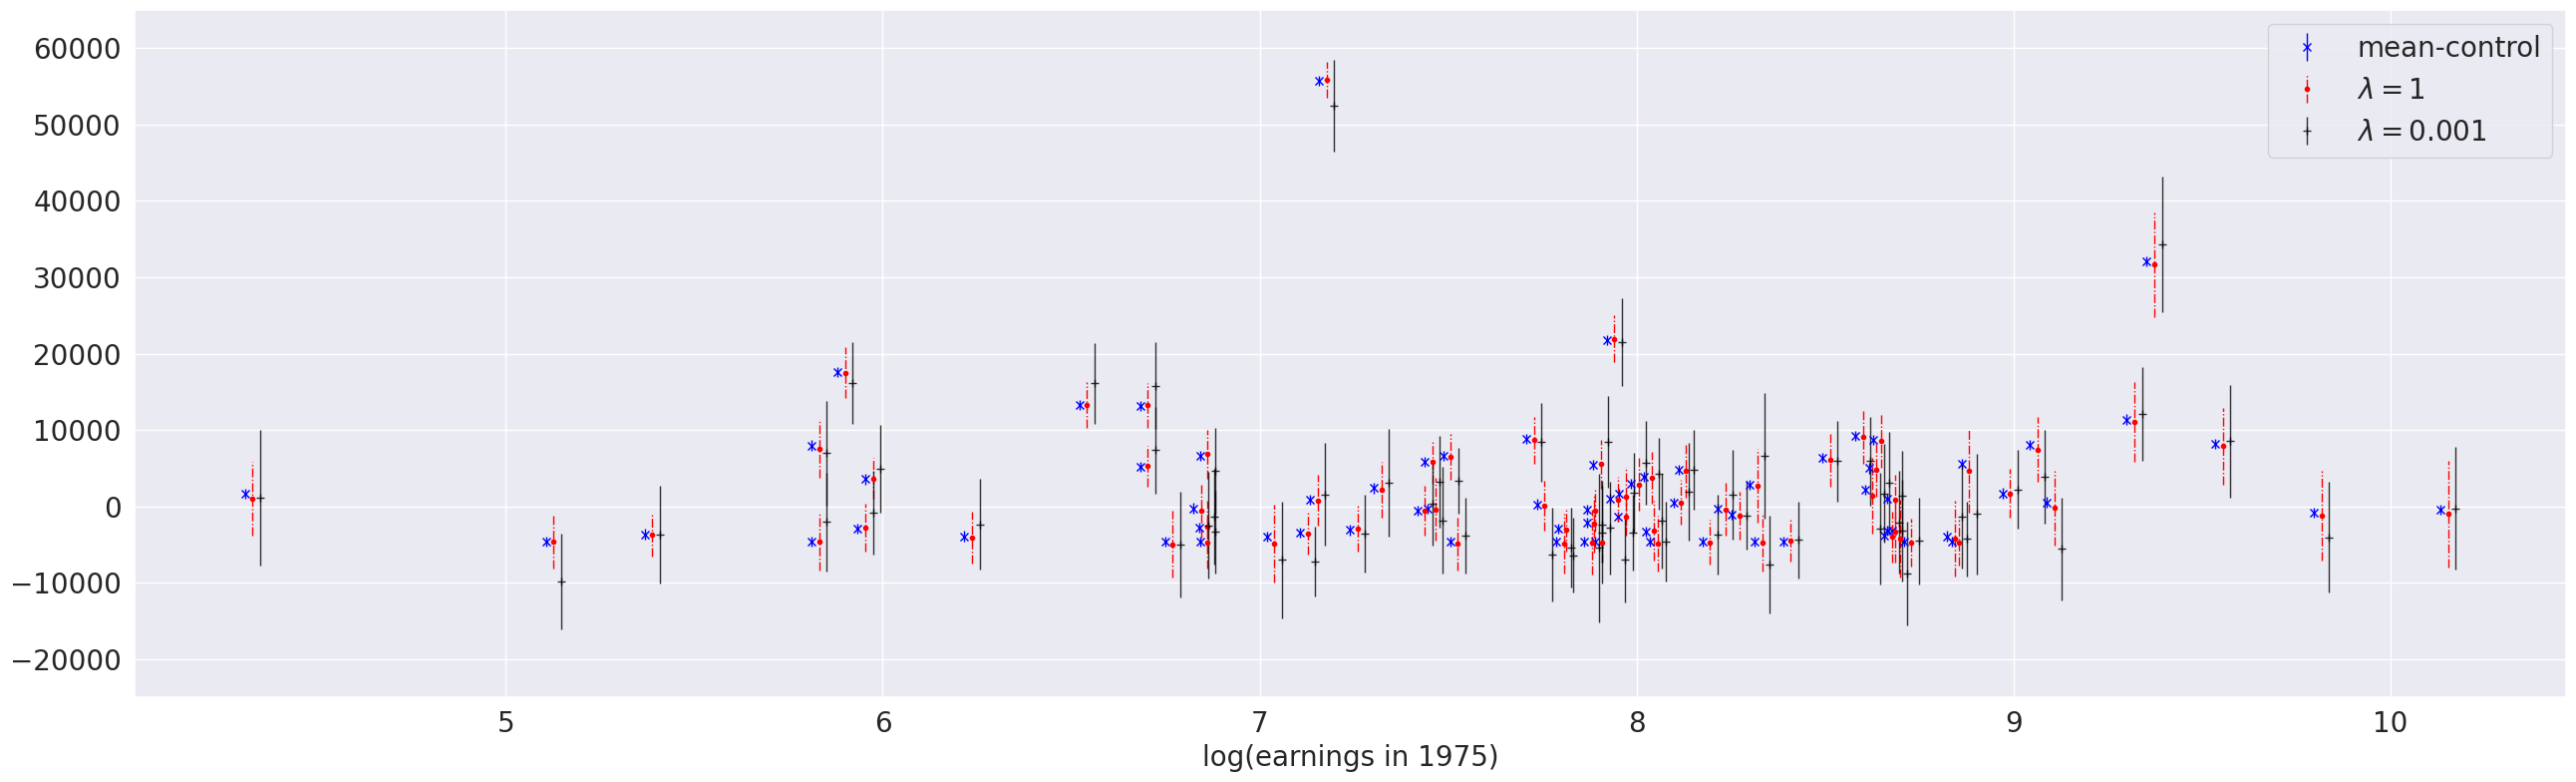

In [5]:
# Gaussian quantile
alpha = 0.05
q_norm = norm.ppf(1-alpha/2)

# radius
p = N_t * pi_lin1
p_ss = np.sqrt(np.sum(p**2, axis=0))
variance_term = q_norm * s_hat * p_ss
bias_term = f0_norm_hat*np.sqrt(np.diag(K_t) + np.diag(p.T @ K_c @ p) - 2.0 * np.diag(p.T @ K_ct))
rad1 = bias_term + variance_term

p = N_t * pi_lin0001
p_ss = np.sqrt(np.sum(p**2, axis=0))
variance_term = q_norm * s_hat * p_ss
bias_term = f0_norm_hat*np.sqrt(np.diag(K_t) + np.diag(p.T @ K_c @ p) - 2.0 * np.diag(p.T @ K_ct))
rad0001 = bias_term + variance_term


# ITEs vs pretreatment outcome 1975
# consider units with earnings in 1975
id75 = dw_t['re75'] > 0
log75 = np.log(dw_t['re75'][id75])  # (74,)

fig = plt.figure(figsize=(26, 8))
plt.errorbar(log75, Y_t[id75] - np.mean(Y_c), yerr=q_norm*np.std(Y_c, ddof=1)/np.sqrt(N_c), fmt='x', color='blue', elinewidth=1, label='mean-control')
eb=plt.errorbar(log75+0.02, tau_lin1[id75], yerr=rad1[id75], fmt='.', color='red', elinewidth=1, label=r'$\lambda=1$')
eb[-1][0].set_linestyle('-.')
plt.errorbar(log75+0.04, tau_lin0001[id75], yerr=rad0001[id75], fmt='+', color='black', alpha=0.8, elinewidth=1, label=r'$\lambda=0.001$')
plt.ylim(-25000,65000)
plt.xlabel('log(earnings in 1975)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
fig.tight_layout()
plt.savefig('figs/NSW_ITEvs75_lin.pdf')
plt.show()

Polynomial

In [6]:
# kernel matrices (polynomial)
K_c = polynomial_kernel(X_c, degree=2) # (N_c, N_c)
K_ct = polynomial_kernel(X_c, X_t, degree=2)  # (N_c, N_t)
K_t = polynomial_kernel(X_t, degree=2)  # (N_t, N_t)

# load the saved results
pi_poly1 = np.load('results/NSW_poly1.npy')
pi_poly0001 = np.load('results/NSW_poly0001.npy')

Y_c_poly1 = N_t * Y_c @ pi_poly1
tau_poly1 = Y_t - Y_c_poly1

Y_c_poly0001 = N_t * Y_c @ pi_poly0001
tau_poly0001 = Y_t - Y_c_poly0001

Kernel ridge regression

In [7]:
np.random.seed(123)
rho_range = np.array([0.1, 0.5, 1, 5, 10])*N_c

K = 5
err = np.zeros((len(rho_range), K))
sigma_estimates = np.zeros(len(rho_range))
f0_norm_estimates = np.zeros(len(rho_range))

for i, rho in enumerate(rho_range):
    kf = KFold(n_splits=K, shuffle=True)

    for j, (train_index, test_index) in enumerate(kf.split(X_c)):
        X_c_tr = X_c[train_index,:]
        X_c_test = X_c[test_index,:]

        Y_c_tr = Y_c[train_index]
        Y_c_test = Y_c[test_index]

        K_c_tr = polynomial_kernel(X_c_tr, degree=2)
        N_c_tr = X_c_tr.shape[0]
        alpha_hat_tr = np.linalg.pinv(K_c_tr + np.eye(N_c_tr)*rho) @ Y_c_tr
        K_c_test = polynomial_kernel(X_c_test, X_c_tr, degree=2)
        err[i,j] = np.mean((Y_c_test - K_c_test @ alpha_hat_tr)**2)
    
    alpha_hat = np.linalg.pinv(K_c + np.eye(N_c)*rho) @ Y_c
    Y_c_fit = K_c @ alpha_hat
    krr_res = Y_c - Y_c_fit
    sigma_estimates[i] = np.std(krr_res, ddof=0)
    f0_norm_estimates[i] = np.sqrt(np.dot(alpha_hat, Y_c_fit))


print(np.mean(err, axis=1))
print(sigma_estimates)
print(f0_norm_estimates)

rho_id = np.argmin(np.mean(err, axis=1))
rho = rho_range[rho_id]
print('rho =', rho) # 260
s_hat = sigma_estimates[rho_id]
f0_norm_hat = f0_norm_estimates[rho_id]
print(f'f0_norm_hat = {f0_norm_hat} and s_hat = {s_hat}')

[31173920.29170254 30306400.0754166  30278666.59884503 31014089.45399664
 31430129.7824508 ]
[5247.25187055 5339.04692483 5372.99582384 5462.29493726 5495.00009246]
[2555.42640602 1214.98814162  961.8359921   611.41156808  518.40167342]
rho = 260.0
f0_norm_hat = 961.8359920988803 and s_hat = 5372.995823837078


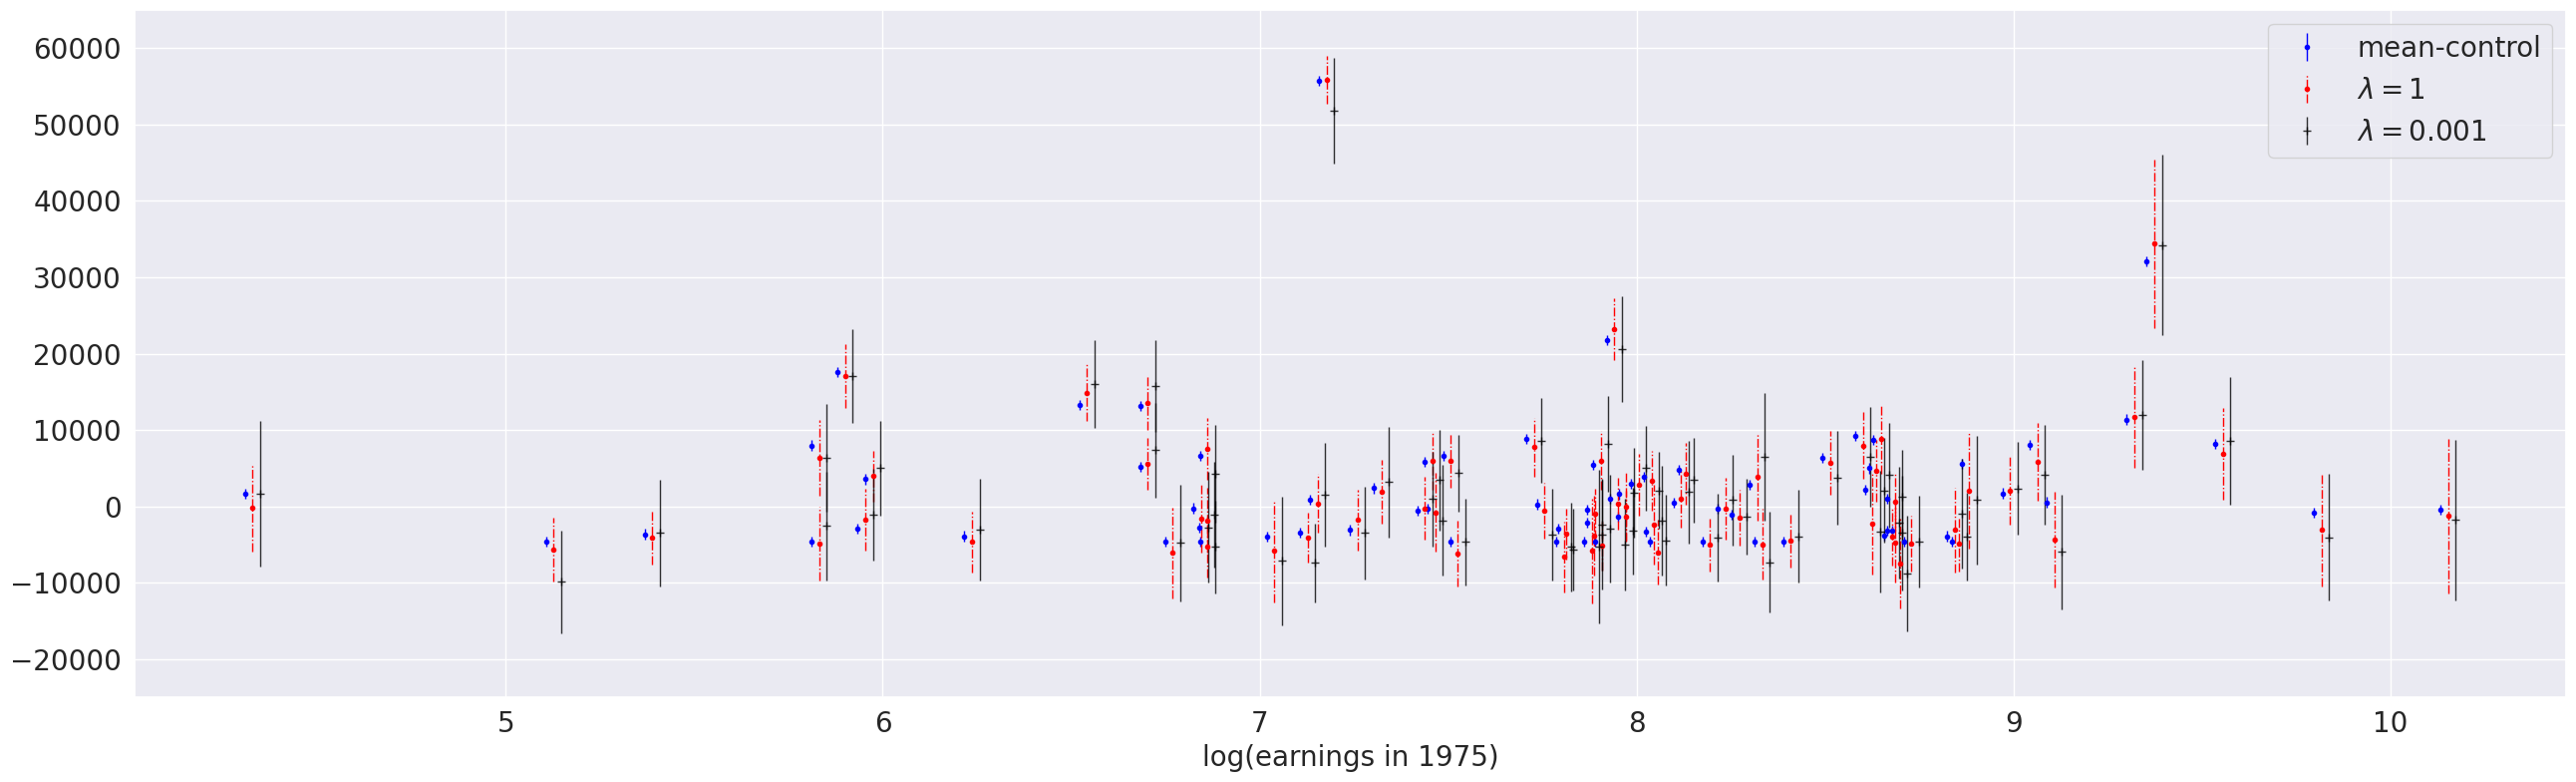

In [8]:
# Gaussian quantile
alpha = 0.05
q_norm = norm.ppf(1-alpha/2)

# radius
p = N_t * pi_poly1
p_ss = np.sqrt(np.sum(p**2, axis=0))
variance_term = q_norm * s_hat * p_ss
bias_term = f0_norm_hat*np.sqrt(np.diag(K_t) + np.diag(p.T @ K_c @ p) - 2.0 * np.diag(p.T @ K_ct))
rad1 = bias_term + variance_term

p = N_t * pi_poly0001
p_ss = np.sqrt(np.sum(p**2, axis=0))
variance_term = q_norm * s_hat * p_ss
bias_term = f0_norm_hat*np.sqrt(np.diag(K_t) + np.diag(p.T @ K_c @ p) - 2.0 * np.diag(p.T @ K_ct))
rad0001 = bias_term + variance_term


# ITEs vs pretreatment outcome 1975
# consider units with earnings in 1975
id75 = dw_t['re75'] > 0
log75 = np.log(dw_t['re75'][id75])  # (74,)

fig = plt.figure(figsize=(26, 8))
plt.errorbar(log75, Y_t[id75] - np.mean(Y_c), yerr=q_norm*np.std(Y_c, ddof=1)/np.sqrt(N_c), fmt='.', color='blue', elinewidth=1, label='mean-control')
eb=plt.errorbar(log75+0.02, tau_poly1[id75], yerr=rad1[id75], fmt='.', color='red', elinewidth=1, label=r'$\lambda=1$')
eb[-1][0].set_linestyle('-.')
plt.errorbar(log75+0.04, tau_poly0001[id75], yerr=rad0001[id75], fmt='+', color='black', alpha=0.8, elinewidth=1, label=r'$\lambda=0.001$')
plt.ylim(-25000,65000)
plt.xlabel('log(earnings in 1975)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
fig.tight_layout()
plt.savefig('figs/NSW_ITEvs75_poly.pdf')
plt.show()

RBF

In [9]:
# kernel matrices (RBF)
K_c = rbf_kernel(X_c) # (N_c, N_c)
K_ct = rbf_kernel(X_c, X_t)  # (N_c, N_t)
K_t = rbf_kernel(X_t)  # (N_t, N_t)

# load the saved results
pi_rbf1 = np.load('results/NSW_rbf1.npy')
pi_rbf0001 = np.load('results/NSW_rbf0001.npy')

Y_c_rbf1 = N_t * Y_c @ pi_rbf1
tau_rbf1 = Y_t - Y_c_rbf1

Y_c_rbf0001 = N_t * Y_c @ pi_rbf0001
tau_rbf0001 = Y_t - Y_c_rbf0001

Kernel ridge regression

In [10]:
np.random.seed(123)
rho_range = np.array([0.1, 0.5, 1, 5, 10])*N_c

K = 5
err = np.zeros((len(rho_range), K))
sigma_estimates = np.zeros(len(rho_range))
f0_norm_estimates = np.zeros(len(rho_range))

for i, rho in enumerate(rho_range):
    kf = KFold(n_splits=K, shuffle=True)

    for j, (train_index, test_index) in enumerate(kf.split(X_c)):
        X_c_tr = X_c[train_index,:]
        X_c_test = X_c[test_index,:]

        Y_c_tr = Y_c[train_index]
        Y_c_test = Y_c[test_index]

        K_c_tr = rbf_kernel(X_c_tr)
        N_c_tr = X_c_tr.shape[0]
        alpha_hat_tr = np.linalg.pinv(K_c_tr + np.eye(N_c_tr)*rho) @ Y_c_tr
        K_c_test = rbf_kernel(X_c_test, X_c_tr)
        err[i,j] = np.mean((Y_c_test - K_c_test @ alpha_hat_tr)**2)
    
    alpha_hat = np.linalg.pinv(K_c + np.eye(N_c)*rho) @ Y_c
    Y_c_fit = K_c @ alpha_hat
    krr_res = Y_c - Y_c_fit
    sigma_estimates[i] = np.std(krr_res, ddof=0)
    f0_norm_estimates[i] = np.sqrt(np.dot(alpha_hat, Y_c_fit))


print(np.mean(err, axis=1))
print(sigma_estimates)
print(f0_norm_estimates)

rho_id = np.argmin(np.mean(err, axis=1))
rho = rho_range[rho_id]
print('rho =', rho) # 26
s_hat = sigma_estimates[rho_id]
f0_norm_hat = f0_norm_estimates[rho_id]
print(f'f0_norm_hat = {f0_norm_hat} and s_hat = {s_hat}')

[35801196.16664442 42346598.2693555  45145764.70878866 49267135.39422573
 49942415.66065881]
[5534.18951464 5560.30764931 5529.59761283 5486.70467987 5480.09936609]
[6489.87358771 2758.77878666 1694.5488475   421.86669501  217.84729113]
rho = 26.0
f0_norm_hat = 6489.873587714774 and s_hat = 5534.189514644009


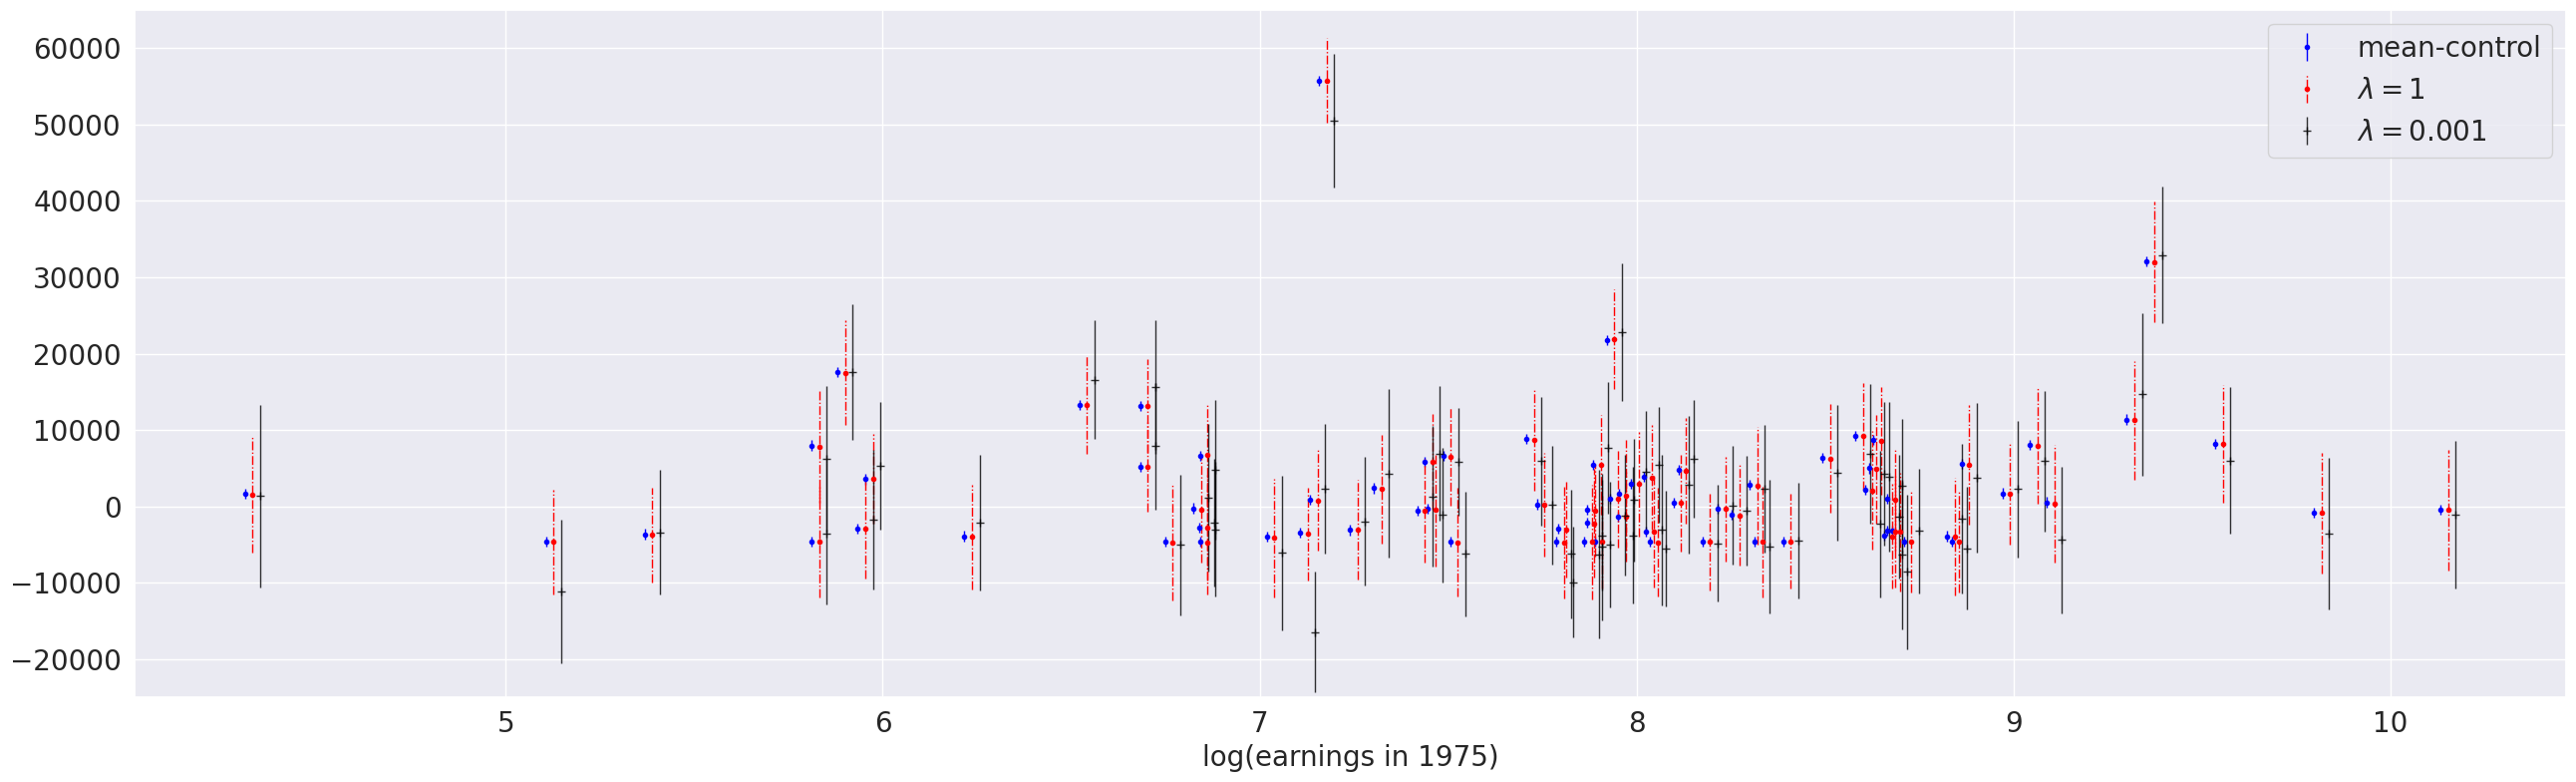

In [11]:
# Gaussian quantile
alpha = 0.05
q_norm = norm.ppf(1-alpha/2)

# radius
p = N_t * pi_rbf1
p_ss = np.sqrt(np.sum(p**2, axis=0))
variance_term = q_norm * s_hat * p_ss
bias_term = f0_norm_hat*np.sqrt(np.diag(K_t) + np.diag(p.T @ K_c @ p) - 2.0 * np.diag(p.T @ K_ct))
rad1 = bias_term + variance_term

p = N_t * pi_rbf0001
p_ss = np.sqrt(np.sum(p**2, axis=0))
variance_term = q_norm * s_hat * p_ss
bias_term = f0_norm_hat*np.sqrt(np.diag(K_t) + np.diag(p.T @ K_c @ p) - 2.0 * np.diag(p.T @ K_ct))
rad0001 = bias_term + variance_term


# ITEs vs pretreatment outcome 1975
# consider units with earnings in 1975
id75 = dw_t['re75'] > 0
log75 = np.log(dw_t['re75'][id75])  # (74,)

fig = plt.figure(figsize=(26, 8))
plt.errorbar(log75, Y_t[id75] - np.mean(Y_c), yerr=q_norm*np.std(Y_c, ddof=1)/np.sqrt(N_c), fmt='.', color='blue', elinewidth=1, label='mean-control')
eb=plt.errorbar(log75+0.02, tau_rbf1[id75], yerr=rad1[id75], fmt='.', color='red', elinewidth=1, label=r'$\lambda=1$')
eb[-1][0].set_linestyle('-.')
plt.errorbar(log75+0.04, tau_rbf0001[id75], yerr=rad0001[id75], fmt='+', color='black', alpha=0.8, elinewidth=1, label=r'$\lambda=0.001$')
plt.ylim(-25000,65000)
plt.xlabel('log(earnings in 1975)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
fig.tight_layout()
plt.savefig('figs/NSW_ITEvs75_rbf.pdf')
plt.show()

# PSID Control

In [12]:
df_psid = pd.read_stata('data/NSW/psid_controls.dta')
df_psid = df_psid.drop(columns='data_id')   # (2490, 10)

# unemployed in 1974 or 1975
df_psid['u74'] = np.where(df_psid['re74']==0, 1, 0)
df_psid['u75'] = np.where(df_psid['re75']==0, 1, 0)

N_psid = df_psid.shape[0]
Y_psid = df_psid['re78'].to_numpy()  # observed outcomes
X_psid = df_psid.drop(columns=['treat','re78']).to_numpy()    # (2490, 10)
X_psid = X_psid / np.std(X_psid, axis=0, ddof=1)

print('ATT by mean difference =', np.mean(Y_t) - np.mean(Y_psid))

# pool the Dehejia-Wahba treated sample and the CPS controls
df_t_psid = pd.concat([dw_t, df_psid])

# logistic regression to estimate the propensity score
res_psid = smf.glm(formula="treat~age+I(age**2)+I(age**3)+education+I(education**2)+black+hispanic+married+nodegree+re74+re75+u74+u75+education:re74", data=df_t_psid, family=sm.families.Binomial()).fit()

# estimated propensity scores
ps_t_psid = res_psid.predict(dw_t)
ps_psid = res_psid.predict(df_psid)

# ATT via IPW-Hajek
print('ATT by IPW normalized =', np.mean(Y_t) - np.sum(Y_psid*ps_psid/(1-ps_psid))/np.sum(ps_psid/(1-ps_psid)))

ATT by mean difference = -15204.777
ATT by IPW normalized = 2579.660946046965


# Trimmed PSID Control

In [13]:
# discard values outside of [0.1, 0.9]
id_psid = (ps_psid>=0.05) & (ps_psid<=0.95) # 214 observations out of 2490

df_psid_trim = df_psid[id_psid]
N_psid_trim = df_psid_trim.shape[0]
Y_psid_trim = Y_psid[id_psid]
X_psid_trim = df_psid_trim.drop(columns=['treat','re78']).to_numpy()    # (214, 10)
X_psid_trim = X_psid_trim / np.std(X_psid_trim, axis=0, ddof=1)

ps_psid_trim = ps_psid[id_psid]
w = ps_psid_trim/(1-ps_psid_trim)
w = w.to_numpy()
w = w / np.sum(w)

print('ATT by mean difference =', np.mean(Y_t) - np.mean(Y_psid_trim))
print('ATT by IPW normalized =', np.mean(Y_t) - np.sum(Y_psid_trim*w))

ATT by mean difference = -1373.4272
ATT by IPW normalized = 1748.0036519053538


Linear

In [14]:
# kernel matrices (linear)
K_psid_trim = X_psid_trim @ X_psid_trim.T / d  # (N_psid_trim, N_psid_trim)
K_ct_psid_trim = X_psid_trim @ X_t.T / d  # (N_psid_trim, N_t)
K_t = X_t @ X_t.T / d  # (N_t, N_t)

# load the saved results
pi_lin1_psid_trim = np.load('results/PSIDtrim-IPW_lin1.npy')
pi_lin0001_psid_trim = np.load('results/PSIDtrim-IPW_lin0001.npy')

Y_c_lin1_psid_trim = N_t * Y_psid_trim @ pi_lin1_psid_trim
tau_lin1_psid_trim = Y_t - Y_c_lin1_psid_trim

Y_c_lin0001_psid_trim = N_t * Y_psid_trim @ pi_lin0001_psid_trim
tau_lin0001_psid_trim = Y_t - Y_c_lin0001_psid_trim

Kernel ridge regression

In [15]:
np.random.seed(312)
rho_range = np.array([0.1, 0.5, 1, 5, 10])*N_psid_trim

K = 5
err = np.zeros((len(rho_range), K))
sigma_estimates = np.zeros(len(rho_range))
f0_norm_estimates = np.zeros(len(rho_range))

for i, rho in enumerate(rho_range):
    kf = KFold(n_splits=K, shuffle=True)

    for j, (train_index, test_index) in enumerate(kf.split(X_psid_trim)):
        X_psid_trim_tr = X_psid_trim[train_index,:]
        X_psid_trim_test = X_psid_trim[test_index,:]

        Y_psid_trim_tr = Y_psid_trim[train_index]
        Y_psid_trim_test = Y_psid_trim[test_index]

        K_psid_trim_tr = X_psid_trim_tr @ X_psid_trim_tr.T / d
        N_psid_trim_tr = X_psid_trim_tr.shape[0]
        alpha_hat_tr = np.linalg.pinv(K_psid_trim_tr + np.eye(N_psid_trim_tr)*rho) @ Y_psid_trim_tr
        K_psid_trim_test = X_psid_trim_test @ X_psid_trim_tr.T / d        
        err[i,j] = np.mean((Y_psid_trim_test - K_psid_trim_test @ alpha_hat_tr)**2)
    
    alpha_hat = np.linalg.pinv(K_psid_trim + np.eye(N_psid_trim)*rho) @ Y_psid_trim
    Y_psid_trim_fit = K_psid_trim @ alpha_hat
    krr_res = Y_psid_trim - Y_psid_trim_fit
    sigma_estimates[i] = np.std(krr_res, ddof=0)
    f0_norm_estimates[i] = np.sqrt(np.dot(alpha_hat, Y_psid_trim_fit))


print(np.mean(err, axis=1))
print(sigma_estimates)
print(f0_norm_estimates)

rho_id = np.argmin(np.mean(err, axis=1))
rho = rho_range[rho_id]
print('rho =', rho) # 21.4
s_hat = sigma_estimates[rho_id]
f0_norm_hat = f0_norm_estimates[rho_id]
print(f'f0_norm_hat = {f0_norm_hat} and s_hat = {s_hat}')

[9.82569974e+07 1.05904653e+08 1.12491783e+08 1.32575275e+08
 1.45552645e+08]
[ 9586.35203908 10070.190763   10281.94840192 10567.90204504
 10617.56491197]
[8210.7252641  4550.28217347 3537.06404246 1784.41091796 1153.18227035]
rho = 21.400000000000002
f0_norm_hat = 8210.725264101615 and s_hat = 9586.352039075286


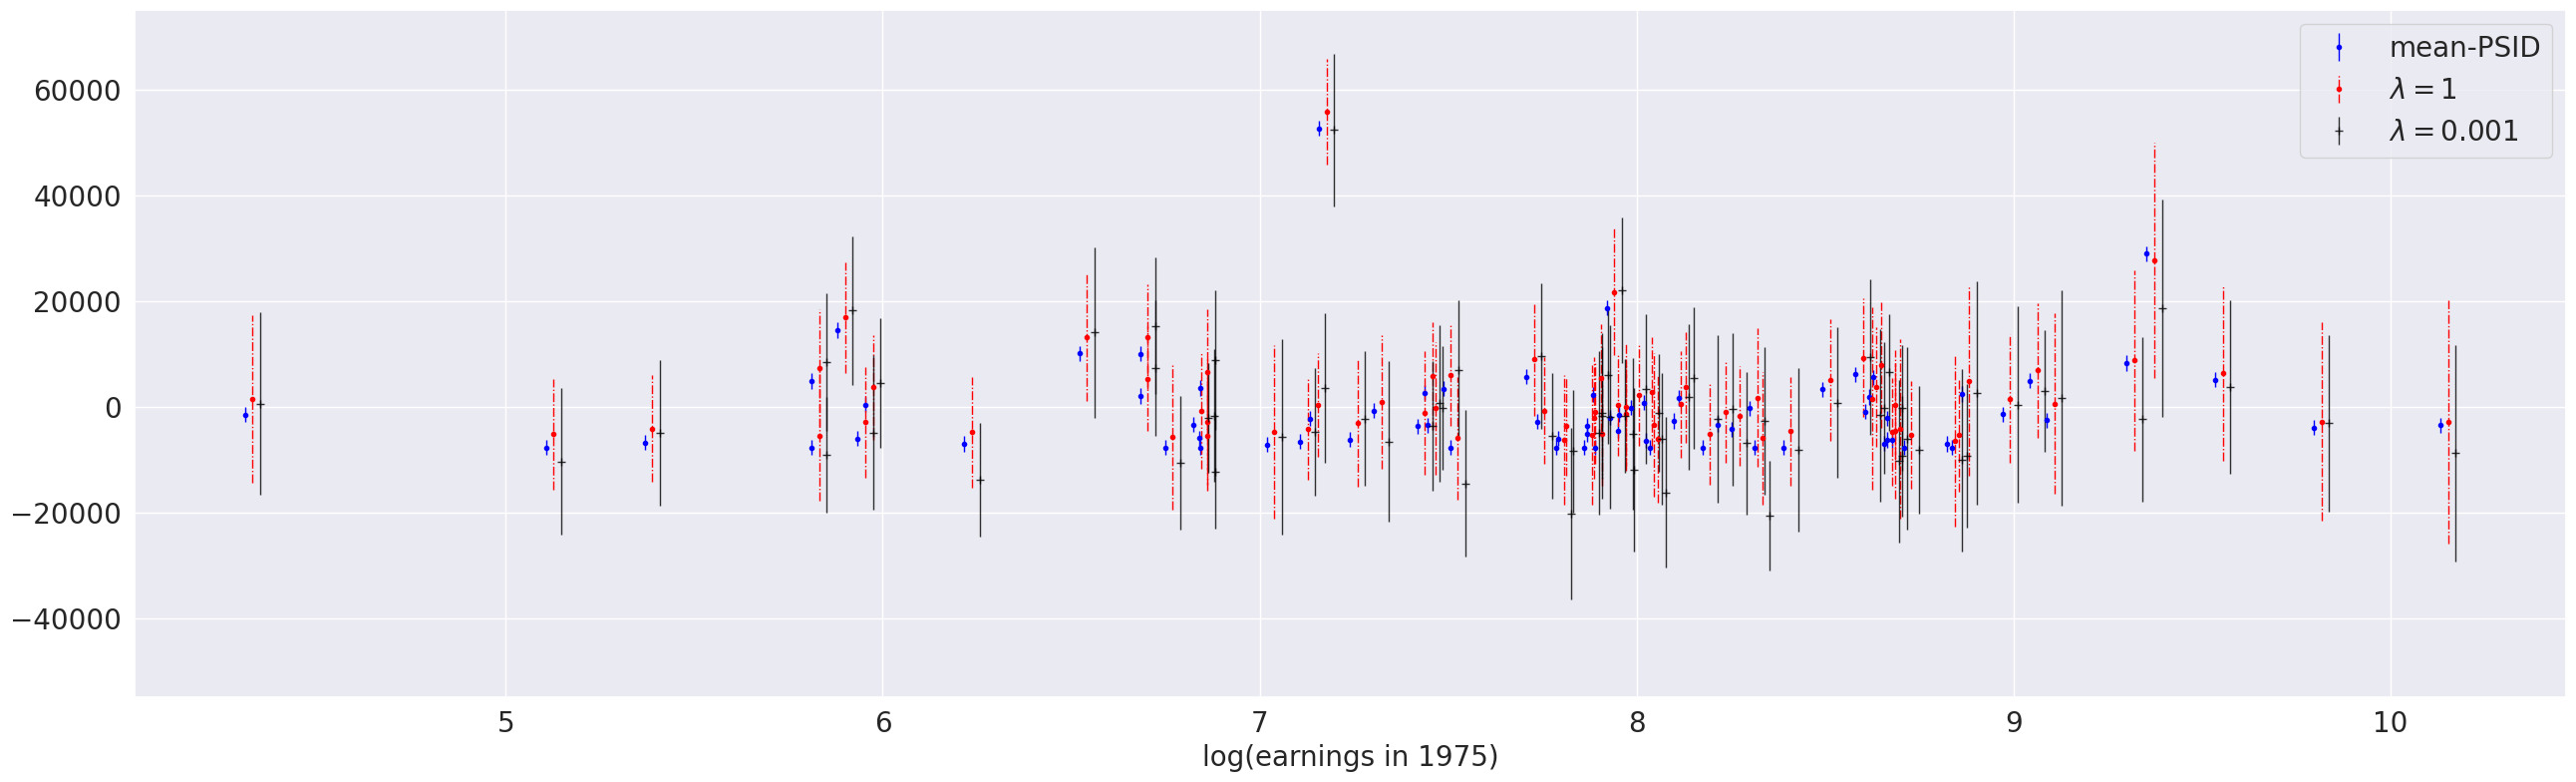

In [16]:
# Gaussian quantile
alpha = 0.05
q_norm = norm.ppf(1-alpha/2)

# radius
p = N_t * pi_lin1_psid_trim
p_ss = np.sqrt(np.sum(p**2, axis=0))
variance_term = q_norm * s_hat * p_ss
bias_term = f0_norm_hat*np.sqrt(np.diag(K_t) + np.diag(p.T @ K_psid_trim @ p) - 2.0 * np.diag(p.T @ K_ct_psid_trim))
rad1 = bias_term + variance_term

p = N_t * pi_lin0001_psid_trim
p_ss = np.sqrt(np.sum(p**2, axis=0))
variance_term = q_norm * s_hat * p_ss
bias_term = f0_norm_hat*np.sqrt(np.diag(K_t) + np.diag(p.T @ K_psid_trim @ p) - 2.0 * np.diag(p.T @ K_ct_psid_trim))
rad0001 = bias_term + variance_term


# ITEs vs pretreatment outcome 1975
# consider units with earnings in 1975
id75 = dw_t['re75'] > 0
log75 = np.log(dw_t['re75'][id75])  # (74,)

fig = plt.figure(figsize=(26, 8))
plt.errorbar(log75, Y_t[id75] - np.mean(Y_psid_trim), yerr=q_norm*np.std(Y_psid_trim, ddof=1)/np.sqrt(N_psid_trim), fmt='.', color='blue', elinewidth=1, label='mean-PSID')
eb=plt.errorbar(log75+0.02, tau_lin1_psid_trim[id75], yerr=rad1[id75], fmt='.', color='red', elinewidth=1, label=r'$\lambda=1$')
eb[-1][0].set_linestyle('-.')
plt.errorbar(log75+0.04, tau_lin0001_psid_trim[id75], yerr=rad0001[id75], fmt='+', color='black', alpha=0.8, elinewidth=1, label=r'$\lambda=0.001$')
plt.ylim(-55000,75000)
plt.xlabel('log(earnings in 1975)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
fig.tight_layout()
plt.savefig('figs/PSIDtrim-IPW_ITEvs75_lin.pdf')
plt.show()

Polynomial

In [17]:
# kernel matrices (polynomial)
K_psid_trim = polynomial_kernel(X_psid_trim, degree=2)  # (N_psid_trim, N_psid_trim)
K_ct_psid_trim = polynomial_kernel(X_psid_trim, X_t, degree=2)  # (N_psid_trim, N_t)
K_t = polynomial_kernel(X_t, degree=2)  # (N_t, N_t)

# load the saved results
pi_poly1_psid_trim = np.load('results/PSIDtrim-IPW_poly1.npy')
pi_poly0001_psid_trim = np.load('results/PSIDtrim-IPW_poly0001.npy')

Y_c_poly1_psid_trim = N_t * Y_psid_trim @ pi_poly1_psid_trim
tau_poly1_psid_trim = Y_t - Y_c_poly1_psid_trim

Y_c_poly0001_psid_trim = N_t * Y_psid_trim @ pi_poly0001_psid_trim
tau_poly0001_psid_trim = Y_t - Y_c_poly0001_psid_trim

Kernel ridge regression

In [18]:
np.random.seed(123)
rho_range = np.array([0.1, 0.5, 1, 5, 10])*N_psid_trim

K = 5
err = np.zeros((len(rho_range), K))
sigma_estimates = np.zeros(len(rho_range))
f0_norm_estimates = np.zeros(len(rho_range))

for i, rho in enumerate(rho_range):
    kf = KFold(n_splits=K, shuffle=True)

    for j, (train_index, test_index) in enumerate(kf.split(X_psid_trim)):
        X_psid_trim_tr = X_psid_trim[train_index,:]
        X_psid_trim_test = X_psid_trim[test_index,:]

        Y_psid_trim_tr = Y_psid_trim[train_index]
        Y_psid_trim_test = Y_psid_trim[test_index]

        K_psid_trim_tr = polynomial_kernel(X_psid_trim_tr, degree=2)
        N_psid_trim_tr = X_psid_trim_tr.shape[0]
        alpha_hat_tr = np.linalg.pinv(K_psid_trim_tr + np.eye(N_psid_trim_tr)*rho) @ Y_psid_trim_tr
        K_psid_trim_test = polynomial_kernel(X_psid_trim_test, X_psid_trim_tr, degree=2)
        err[i,j] = np.mean((Y_psid_trim_test - K_psid_trim_test @ alpha_hat_tr)**2)
    
    alpha_hat = np.linalg.pinv(K_psid_trim + np.eye(N_psid_trim)*rho) @ Y_psid_trim
    Y_psid_trim_fit = K_psid_trim @ alpha_hat
    krr_res = Y_psid_trim - Y_psid_trim_fit
    sigma_estimates[i] = np.std(krr_res, ddof=0)
    f0_norm_estimates[i] = np.sqrt(np.dot(alpha_hat, Y_psid_trim_fit))


print(np.mean(err, axis=1))
print(sigma_estimates)
print(f0_norm_estimates)

rho_id = np.argmin(np.mean(err, axis=1))
rho = rho_range[rho_id]
print('rho =', rho) # 107.0
s_hat = sigma_estimates[rho_id]
f0_norm_hat = f0_norm_estimates[rho_id]
print(f'f0_norm_hat = {f0_norm_hat} and s_hat = {s_hat}')

[1.00530880e+08 9.67878389e+07 9.88362167e+07 1.04649760e+08
 1.12741886e+08]
[ 8946.28616119  9311.6206931   9465.32929482  9976.26991873
 10214.87071946]
[6837.37432922 3441.87710801 2767.50125184 1605.07092082 1235.21475219]
rho = 107.0
f0_norm_hat = 3441.877108010765 and s_hat = 9311.620693102386


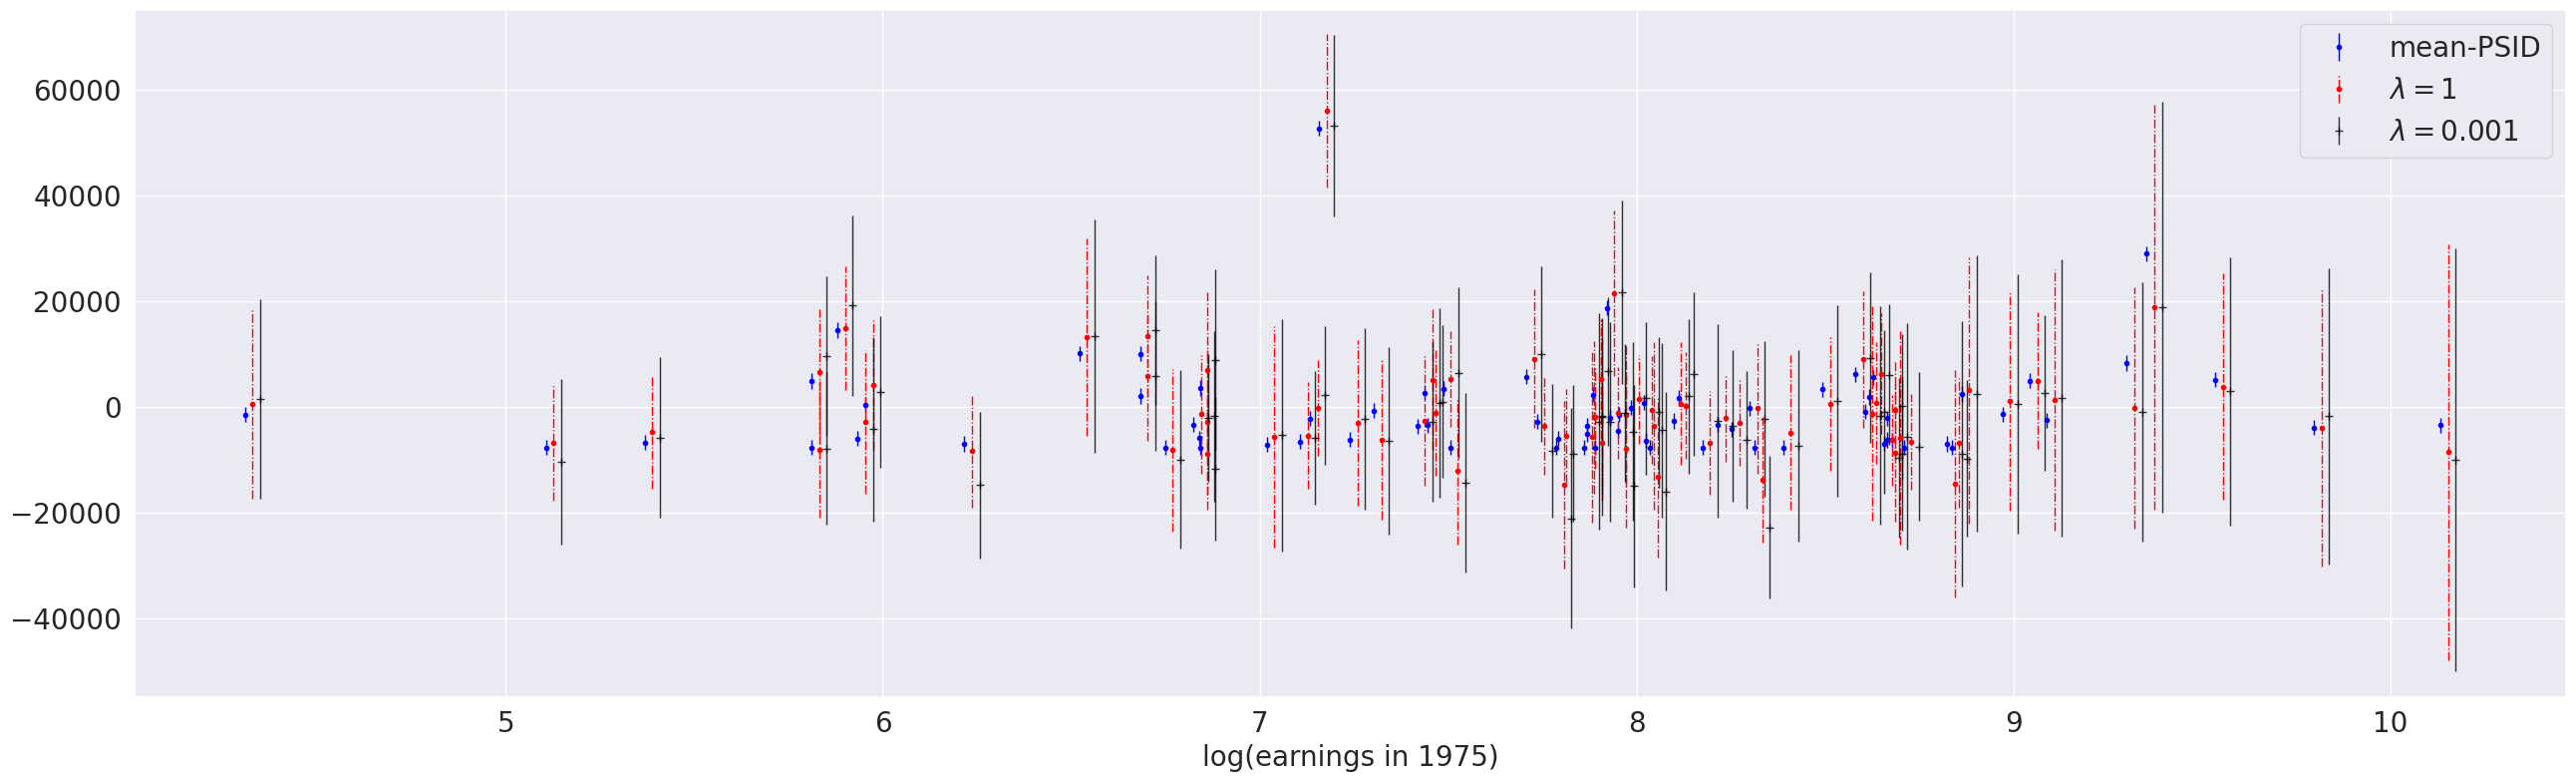

In [19]:
# Gaussian quantile
alpha = 0.05
q_norm = norm.ppf(1-alpha/2)

# radius
p = N_t * pi_poly1_psid_trim
p_ss = np.sqrt(np.sum(p**2, axis=0))
variance_term = q_norm * s_hat * p_ss
bias_term = f0_norm_hat*np.sqrt(np.diag(K_t) + np.diag(p.T @ K_psid_trim @ p) - 2.0 * np.diag(p.T @ K_ct_psid_trim))
rad1 = bias_term + variance_term

p = N_t * pi_poly0001_psid_trim
p_ss = np.sqrt(np.sum(p**2, axis=0))
variance_term = q_norm * s_hat * p_ss
bias_term = f0_norm_hat*np.sqrt(np.diag(K_t) + np.diag(p.T @ K_psid_trim @ p) - 2.0 * np.diag(p.T @ K_ct_psid_trim))
rad0001 = bias_term + variance_term


# ITEs vs pretreatment outcome 1975
# consider units with earnings in 1975
id75 = dw_t['re75'] > 0
log75 = np.log(dw_t['re75'][id75])  # (74,)

fig = plt.figure(figsize=(26, 8))
plt.errorbar(log75, Y_t[id75] - np.mean(Y_psid_trim), yerr=q_norm*np.std(Y_psid_trim, ddof=1)/np.sqrt(N_psid_trim), fmt='.', color='blue', elinewidth=1, label='mean-PSID')
eb=plt.errorbar(log75+0.02, tau_poly1_psid_trim[id75], yerr=rad1[id75], fmt='.', color='red', elinewidth=1, label=r'$\lambda=1$')
eb[-1][0].set_linestyle('-.')
plt.errorbar(log75+0.04, tau_poly0001_psid_trim[id75], yerr=rad0001[id75], fmt='+', color='black', alpha=0.8, elinewidth=1, label=r'$\lambda=0.001$')
plt.ylim(-55000,75000)
plt.xlabel('log(earnings in 1975)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
fig.tight_layout()
plt.savefig('figs/PSIDtrim-IPW_ITEvs75_poly.pdf')
plt.show()

RBF

In [20]:
# kernel matrices (RBF)
K_psid_trim = rbf_kernel(X_psid_trim)  # (N_psid_trim, N_psid_trim)
K_ct_psid_trim = rbf_kernel(X_psid_trim, X_t)  # (N_psid_trim, N_t)
K_t = rbf_kernel(X_t)  # (N_t, N_t)

# load the saved results
pi_rbf1_psid_trim = np.load('results/PSIDtrim-IPW_rbf1.npy')
pi_rbf0001_psid_trim = np.load('results/PSIDtrim-IPW_rbf0001.npy')

Y_c_rbf1_psid_trim = N_t * Y_psid_trim @ pi_rbf1_psid_trim
tau_rbf1_psid_trim = Y_t - Y_c_rbf1_psid_trim

Y_c_rbf0001_psid_trim = N_t * Y_psid_trim @ pi_rbf0001_psid_trim
tau_rbf0001_psid_trim = Y_t - Y_c_rbf0001_psid_trim

Kernel ridge regression

In [21]:
np.random.seed(123)
rho_range = np.array([0.1, 0.5, 1, 5, 10])*N_psid_trim

K = 2
err = np.zeros((len(rho_range), K))
sigma_estimates = np.zeros(len(rho_range))
f0_norm_estimates = np.zeros(len(rho_range))

for i, rho in enumerate(rho_range):
    kf = KFold(n_splits=K, shuffle=True)

    for j, (train_index, test_index) in enumerate(kf.split(X_psid_trim)):
        X_psid_trim_tr = X_psid_trim[train_index,:]
        X_psid_trim_test = X_psid_trim[test_index,:]

        Y_psid_trim_tr = Y_psid_trim[train_index]
        Y_psid_trim_test = Y_psid_trim[test_index]

        K_psid_trim_tr = rbf_kernel(X_psid_trim_tr)
        N_psid_trim_tr = X_psid_trim_tr.shape[0]
        alpha_hat_tr = np.linalg.pinv(K_psid_trim_tr + np.eye(N_psid_trim_tr)*rho) @ Y_psid_trim_tr
        K_psid_trim_test = rbf_kernel(X_psid_trim_test, X_psid_trim_tr)
        err[i,j] = np.mean((Y_psid_trim_test - K_psid_trim_test @ alpha_hat_tr)**2)
    
    alpha_hat = np.linalg.pinv(K_psid_trim + np.eye(N_psid_trim)*rho) @ Y_psid_trim
    Y_psid_trim_fit = K_psid_trim @ alpha_hat
    krr_res = Y_psid_trim - Y_psid_trim_fit
    sigma_estimates[i] = np.std(krr_res, ddof=0)
    f0_norm_estimates[i] = np.sqrt(np.dot(alpha_hat, Y_psid_trim_fit))


print(np.mean(err, axis=1))
print(sigma_estimates)
print(f0_norm_estimates)

rho_id = np.argmin(np.mean(err, axis=1))
rho = rho_range[rho_id]
print('rho =', rho) # 21.4
s_hat = sigma_estimates[rho_id]
f0_norm_hat = f0_norm_estimates[rho_id]
print(f'f0_norm_hat = {f0_norm_hat} and s_hat = {s_hat}')

[1.26165186e+08 1.52512777e+08 1.61723341e+08 1.70746661e+08
 1.72153570e+08]
[10111.09489481 10493.65398664 10567.32307041 10649.25534833
 10662.15853435]
[12970.18142187  5276.40882847  3141.16924806   746.95587546
   382.69701926]
rho = 21.400000000000002
f0_norm_hat = 12970.181421868065 and s_hat = 10111.094894812464


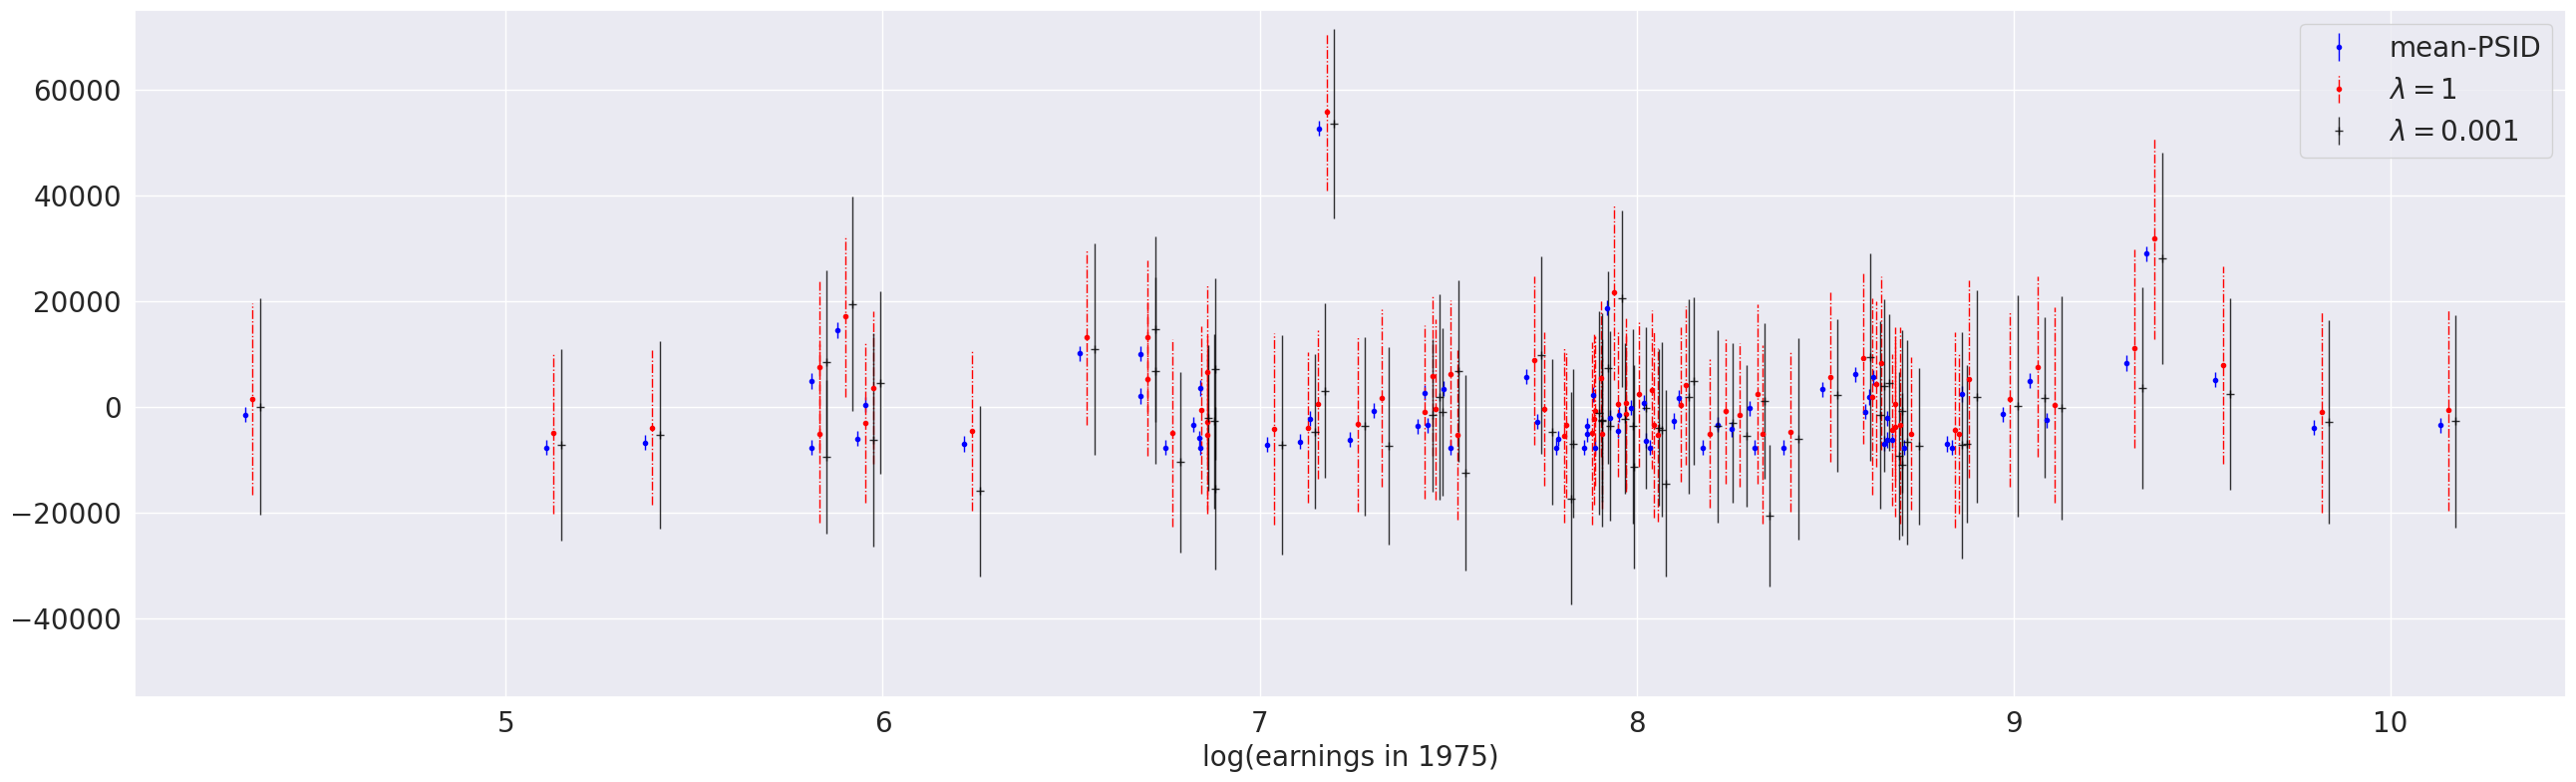

In [22]:
# Gaussian quantile
alpha = 0.05
q_norm = norm.ppf(1-alpha/2)

# radius
p = N_t * pi_rbf1_psid_trim
p_ss = np.sqrt(np.sum(p**2, axis=0))
variance_term = q_norm * s_hat * p_ss
bias_term = f0_norm_hat*np.sqrt(np.diag(K_t) + np.diag(p.T @ K_psid_trim @ p) - 2.0 * np.diag(p.T @ K_ct_psid_trim))
rad1 = bias_term + variance_term

p = N_t * pi_rbf0001_psid_trim
p_ss = np.sqrt(np.sum(p**2, axis=0))
variance_term = q_norm * s_hat * p_ss
bias_term = f0_norm_hat*np.sqrt(np.diag(K_t) + np.diag(p.T @ K_psid_trim @ p) - 2.0 * np.diag(p.T @ K_ct_psid_trim))
rad0001 = bias_term + variance_term


# ITEs vs pretreatment outcome 1975
# consider units with earnings in 1975
id75 = dw_t['re75'] > 0
log75 = np.log(dw_t['re75'][id75])  # (74,)

fig = plt.figure(figsize=(26, 8))
plt.errorbar(log75, Y_t[id75] - np.mean(Y_psid_trim), yerr=q_norm*np.std(Y_psid_trim, ddof=1)/np.sqrt(N_psid_trim), fmt='.', color='blue', elinewidth=1, label='mean-PSID')
eb=plt.errorbar(log75+0.02, tau_rbf1_psid_trim[id75], yerr=rad1[id75], fmt='.', color='red', elinewidth=1, label=r'$\lambda=1$')
eb[-1][0].set_linestyle('-.')
plt.errorbar(log75+0.04, tau_rbf0001_psid_trim[id75], yerr=rad0001[id75], fmt='+', color='black', alpha=0.8, elinewidth=1, label=r'$\lambda=0.001$')
plt.ylim(-55000,75000)
plt.xlabel('log(earnings in 1975)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
fig.tight_layout()
plt.savefig('figs/PSIDtrim-IPW_ITEvs75_rbf.pdf')
plt.show()

In [25]:
print('std of control =', np.std(Y_c, ddof=1))
print('std of PSID trimmed =', np.std(Y_psid_trim, ddof=1))

std of control = 5483.836
std of PSID trimmed = 10700.941
